## Multi-mode data

Finally we repeat the modelling part of this notebook using in this case multiple modes (fundamental, 1st, and 2nd).

In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

from surfacewaves import *
from dispersionspectra import *
from inversion import *

In [2]:
def showDp2ShotGather(cpr, dshift, x, t, i=0):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    color = ['k', 'r', 'g']

    for imode in range(3):
        axs[0].plot(np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), color[imode], lw=4, label=f'Mode{imode}')
    axs[0].legend()
    axs[0].set_xlabel('f [hz]')
    axs[0].set_ylabel('v [km/s]')
    axs[0].set_title('Rayleigh-wave fundamental model dispersion curve');

    axs[1].imshow(dshift.T, cmap='coolwarm', extent=[x[0], x[-1], t[-1], t[0]], vmin=-.15, vmax=.15)
    axs[1].axis('tight')
    axs[1].set_xlabel('Offset [m]')
    axs[1].set_ylabel('Time [s]')
    axs[1].set_title('Shot gather')

    fig.tight_layout()
    # fig.savefig(f'figs/{i:03d}.png', dpi=300)

In [3]:
# Define model as:
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
# true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

h1, h2, h3, h4, h5 = 0.0109, 0.0150, 0.0135, 0.0129, 1.0000
v1, v2, v3, v4, v5 = 0.2332, 0.2842, 0.5000, 0.4000, 1.0000
thick = np.array([h1, h2, h3, h4, h5])
vs = np.array([v1, v2, v3, v4, v5])
true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

# Frequency axis
fdisp = np.linspace(3, 20, 301)

# Periods (must be sorted starting with low periods)
period = np.flipud(1/fdisp)

# Rayleigh-wave fundamental model dispersion curve 
pd = PhaseDispersion(*true_model.T)
cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]


## Synthetic seismogram

Next, we will be using the dispersion relation to create a surface-wave only seismic shot gather. This is of course a highly simplified version of what you would obtain by using the full elastic wave equation; nevertheless, it serves as a good basis to test algorithms used to create dispersion spectra as it does not contain any interference from other modes and other types of waves (e.g., direct arrival, reflections..).

The modelling is performed in the frequency domain as follows:

$$
d(f,x) = s(f) e^{j 2 \pi f x/v(f)}
$$

where $s(f)$ is the frequency spectrum of the source wavelet.

In [4]:
# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

t, x = np.arange(nt)*dt, np.arange(nx)*dx

# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

# Data
dshifts, fs, vfs = [], [], []
for imode in range(3):
    dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                       np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
    dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
    fs.append(f_)
    vfs.append(vf_)
dshift = np.concatenate(dshifts).sum(0)


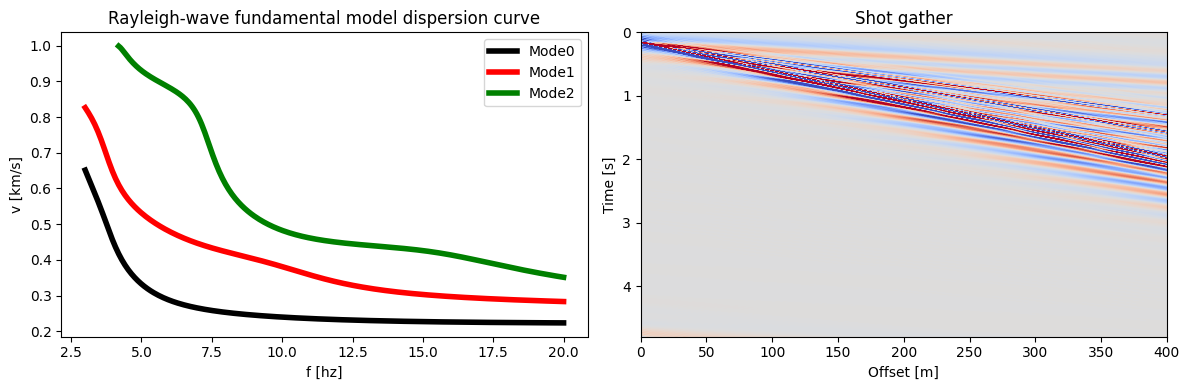

In [5]:
showDp2ShotGather(cpr, dshift, x, t)

In [6]:
import ccfj
import scipy
from Dispersion.dispersion import get_dispersion

dc = 1.
cmin, cmax = 100., 800.
fmin, fmax = fdisp.min(), fdisp.max()

f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)


nx, nt = dshift.shape
x = np.arange(nx)*dx
f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
c = np.linspace(cmin, cmax, 1000)

out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)

(201, 300) (300,) 600 201
Frequency resolution up to 20.00 Hz: 95 bins
Phase velocity resolution up to 800.00 m/s: 700 bins


Text(0.5, 1.0, 'F-J')

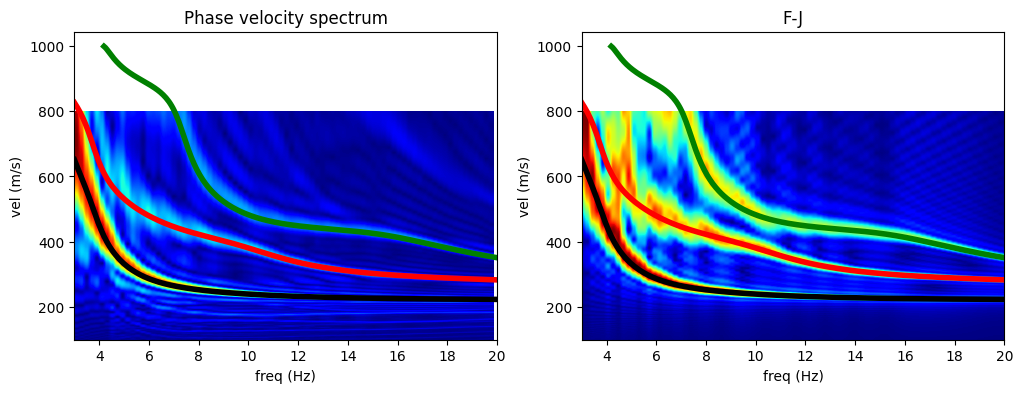

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
color = ['k', 'r', 'g']

axs[0].imshow(img, aspect='auto', cmap='jet',
           extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')
axs[1].imshow(out, aspect='auto', cmap='jet',
           extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

for imode in range(3):
    axs[0].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                color[imode], lw=4, label=f'Mode{imode}')
    axs[1].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                color[imode], lw=4, label=f'Mode{imode}')

axs[0].set_xlim(fmin, fmax)
axs[1].set_xlim(fmin, fmax)

axs[0].set_xlabel('freq (Hz)')
axs[0].set_ylabel('vel (m/s)')
axs[0].set_title('Phase velocity spectrum')
axs[1].set_xlabel('freq (Hz)')
axs[1].set_ylabel('vel (m/s)')
axs[1].set_title('F-J')

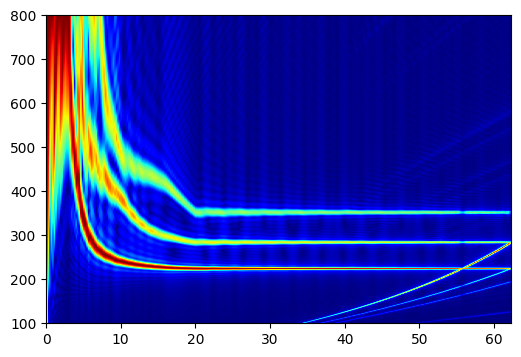

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(out, aspect='auto', cmap='jet',
           extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')


## True Data

In [9]:
dshift.shape, t.shape

((201, 600), (600,))

In [10]:
import pickle

bus_traces, x, t = pickle.load(open('../diffseis/bus_traces_list.pkl', 'rb'))
dx, dt = x[1] - x[0], t[1] - t[0]

dshift = bus_traces.T
# dshift = dshift[:, :t.shape[0]//2]
# t = t[:t.shape[0]//2]

dc = 1.
cmin, cmax = 100., 900.
# Frequency axis
fdisp = np.linspace(2.5, 30, 101)
fmin, fmax = fdisp.min(), fdisp.max()

f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)


nx, nt = dshift.shape
x = np.arange(nx)*dx
f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
c = np.linspace(cmin, cmax, 1000)

out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)

(49, 2000) (2000,) 4001 49
Frequency resolution up to 30.00 Hz: 60 bins
Phase velocity resolution up to 900.00 m/s: 800 bins


(0.0, 50.0)

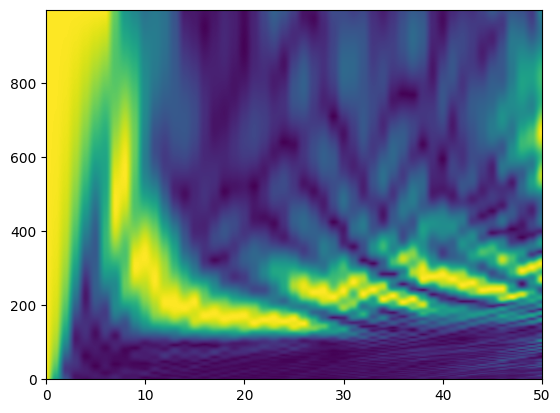

In [11]:
plt.imshow(out, aspect='auto', origin='lower')
plt.xlim(0,50)

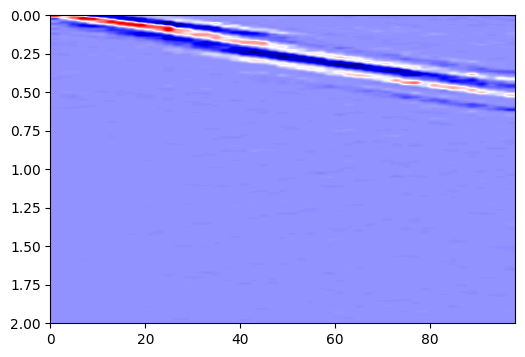

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(dshift.T, aspect='auto', cmap='seismic',
           extent=(x.min(), x.max(),t.max(), t.min()))


Text(0.5, 1.0, 'F-J')

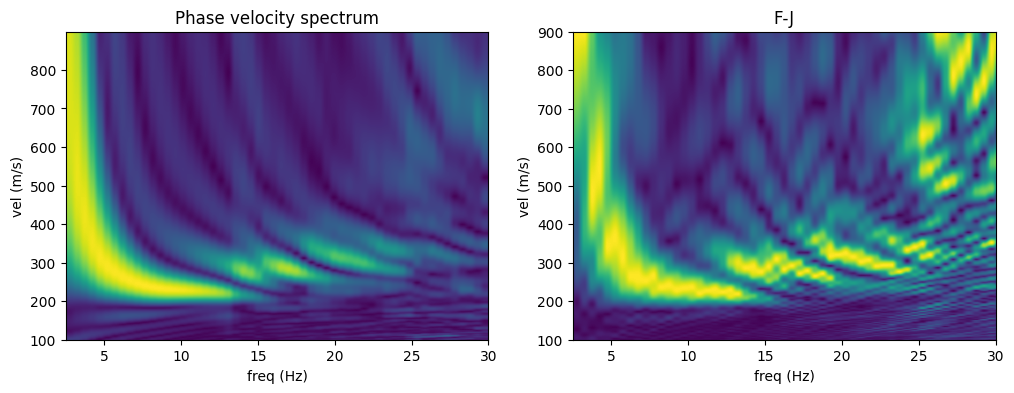

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
color = ['k', 'r', 'g']

axs[0].imshow(img, aspect='auto',
           extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')
axs[1].imshow(out, aspect='auto',
           extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
axs[0].set_xlim(fmin, fmax)
axs[1].set_xlim(fmin, fmax)

axs[0].set_xlabel('freq (Hz)')
axs[0].set_ylabel('vel (m/s)')
axs[0].set_title('Phase velocity spectrum')
axs[1].set_xlabel('freq (Hz)')
axs[1].set_ylabel('vel (m/s)')
axs[1].set_title('F-J')